# Skincare Recommendation System using Collaborative Filtering (Matrix Factorization)

## Introduction

**Have you ever wondered how websites like Bukalapak are so good at suggesting products you might want, even before you start searching for them?**

Well, the answer to this marvel lies in something called "Recommendation Systems." These systems are like your shopping companions in the digital world, and they're pretty good at understanding your preferences and showing you things you'd love.

Let's break it down a bit. Recommendation systems are like helpful friends who pay attention to what you look at, what you buy, and even what you put in your virtual shopping cart. They do this to get a sense of what you like. Then, using some clever math and algorithms, they suggest other products that you might find interesting. That's why you often see suggestions like "People Also Bought" or "You Might Also Like."

But how do these systems know what you'll like? That's what we'll explore **Collaborative filtering** is one of basic models for recommendation system which are based on assumption that people like things similar to other things they like, or things that are liked by other people which have similar taste with them.

Let's dive into the fascinating world of product recommendations in e-commerce!

<img src="assets/New Project.png" width="600" />

<div style="text-align:justify">From the ilustration above, information given that Kiki (girl with black cat) likes to buy apple, banana, and watermelon. While Satsuki (girl with yellow shirt) likes to buy apple and banana. They have similar taste in apple and banana, so we can recommend Satsuki to buy watermelon.<br></div>
In <b>collaborative filtering</b> method there are two approaches which can be implemented :<br>
<b>1. Memory-based approach: </b>create recommendation system by calculated closest users or items using cosine similarity or pearson correlation coefficients.<br>
<b>2. Model-based approach: </b>create recommendation system by given predict user's rating value of unrated items.<br>
<br>
<div style="text-align:justify">In this notebook, I will create simply recommender system to recommend skincare product to the customers which have never buy before. I'll predict the unrated items using Singular Value Decomposition (SVD) of <b>Matrix Factorization</b> algorithm. The data used comes from scraping result in Femaledaily Website. Data contains information about review product given by customers. There are several attribut inside, for more details, let's check it out!</div>

### Library Preparation

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import seaborn as sns
import recmetrics

### Data Preparation

#### Read the Data

In [3]:
data = pd.read_csv("data_input/Skincare.csv")
data

,Reviewer,Stars,Product
0,Ayuika,3,Perfect 3D Gel
1,yustinalupit,4,Perfect 3D Gel
2,evikdanny,3,Perfect 3D Gel
3,daniskhoirun,3,Perfect 3D Gel
4,hulahup19,5,Perfect 3D Gel
...,...,...,...
137295,steph91,4,Ultra Rapid Action Pad
137296,farishaalamsyah,1,Ultra Rapid Action Pad
137297,imeldanababan,4,Ultra Rapid Action Pad
137298,princessvie,3,Ultra Rapid Action Pad


#### Check and drop missing values

In [4]:
data.isna().sum()

Reviewer    0
Stars       0
Product     0
dtype: int64

#### Rename Columns

In [5]:
# rename columns 
data.rename(columns={'Reviewer':'reviewer','Product':'product','Stars':'rating'}, inplace=True)

#### Drop the reviewer with empty names

In [6]:
data = data[data['reviewer'] != ' ']

In [7]:
data

,reviewer,rating,product
0,Ayuika,3,Perfect 3D Gel
1,yustinalupit,4,Perfect 3D Gel
2,evikdanny,3,Perfect 3D Gel
3,daniskhoirun,3,Perfect 3D Gel
4,hulahup19,5,Perfect 3D Gel
...,...,...,...
137295,steph91,4,Ultra Rapid Action Pad
137296,farishaalamsyah,1,Ultra Rapid Action Pad
137297,imeldanababan,4,Ultra Rapid Action Pad
137298,princessvie,3,Ultra Rapid Action Pad


## Data Exploration

Since in the next step (modelling) we will define and create matrix based on Product X User, so we need to understanding about size of both unique product and user.

### Number of Unique Product

In [8]:
uniq_product = data['product'].nunique()
print("Number of uniq product :",uniq_product)

Number of uniq product : 3297


Here above, product have 3297 unique number, this number will become number of columns matrix in modelling step.

### Number of Unique Users

In [9]:
uniq_reviewer = data['reviewer'].nunique()
print("Number of uniq users :",uniq_reviewer)

Number of uniq users : 22359


Here above, user have 22359 unique number, this number will become number of rows matrix in modelling step.

### Distribution rating given by users

<Axes: >

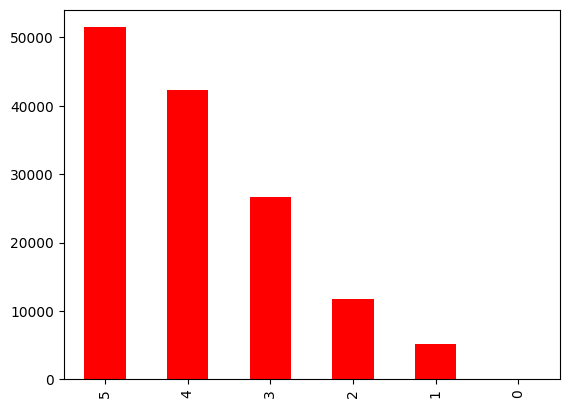

In [13]:
data['rating'].value_counts().plot(kind = 'bar', color = 'red')

From the visualization above, bar plot shown that users frequently give rating in 5 or 4, which mean that they are satisfied with the product.

## Build Recommendation System

### Matrix Factorization

<div style="text-align:justify">If you see the pivot matrix below, you will find that pivot matrix have so many zero value (missing value). Why did it happen? It can be happen because not every user give a rating in a every product, this condition called <b>sparse matrix.</b> Sparse matrix is limitation in collaborative filtering models, because sparse matrix gives bias information in our recommender system. There will be popularity bias in the recommendation given by the system to user, system will give recommends the product with the most interactions without any personalization.<br></div>
<div style="text-align:justify"><b>Matrix Factorization</b> is one way to handle those issue. Matrix factorization will breaking down of one matrix into a product of multiple matrices and give predictive rating in sparse matrix. Basic idea from matrix factorization is that attitudes or preferences of a user can be determined by a small number of hidden factors.<br></div>
Illustration given below:

<img src="assets/matrix.JPG" width="600" />

<div style="text-align:justify">Intuitively, we can understand hidden factors for items and users from illustration above. Say that U is low dimensional matrix for Users features and V is low dimensional matrix for Product features. Every matrix values represent different characteristics about the users and the product. 

We can get the predictive ratings by calculate the dot product between matrix U and matrix V.</div>

### Singular Value Decomposition (SVD)

<div style="text-align:justify"><b>Singular Value Decomposition</b> is one of type Matrix Factorization. SVD algorithm will decomposes a matrix R into the best lower rank approximation of the original matrix R. Matematically SVD produce by the formula below :</div>
<br>
<div style="text-align:center">$ R = U \Sigma V^T $</div>
<br>
<div style="text-align:justify">where U and V are orthogonal matrix with orthonormal eigenvectors and $\sum$ is the diagonal matrix of singular values (essentially weights). The matrix can be factorized as :</div>

<img src="assets/matrix_.jpg" width="400" />

We can arrange eigenvectors in different orders to produce U and V.

### Implementation Recommender System in Python Code

#### 1. Create Matrix Pivot

Create matrix pivot where the vertical value is users name, horizontal value is product name, and the value inside matrix is rating given by users.

In [15]:
matrix_pivot = pd.pivot_table(data, 
                              index = 'reviewer',
                              columns = 'product',
                              values = 'rating').fillna(0)
matrix_pivot.head()

product,"0,2 mm Therapy Air Mask Sheet",10% Lactic Acid (Infused with Rose),100% Cold-Pressed Virgin Marula Oil,100% Organic Cold-Pressed Borage Seed Oil,100% Organic Cold-Pressed Rose Hip Seed Oil,100% Plant-Derived Squalane,100% Pure Camellia Dry Oil,100% Snail mucus Soothing Gel,14% AHA Swipes,2 Minutes Brightening Gel,...,wardah seaweed intensive night cream,wardah suncare,watermelon glow,white beauty aqua facial wash with plant extract,whitening plus complex,whitening soap,wonder pore,zaitun oil,“Buffet”,“B” oil
reviewer,,,,,,,,,,,,,,,,,,,,,
01lely,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01putrisalma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01sary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123hayoapa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15ayusafitri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### 2. Normalize Rating Values

❓ **Why we do need to normalize the rating?**

Because it starts with the fact that people rate often on very different scales. Say that Kiki and Satsuki use a product B, and Kiki gives rating value 5 on that product, because Satsuki has a high standart she only gives 3 on that product. Here is, the 5 from Kiki is 3 from Satsuki. To make the model better is, we can increase the efficiency of this algorithm if we normalize user’s rating by substract rating value given by user in each product with mean rating in each product.

In [16]:
matrix_pivot_ = matrix_pivot.values
user_ratings_mean = np.mean(matrix_pivot_, axis = 1)
user_rating = matrix_pivot_ - user_ratings_mean.reshape(-1,1)

In [18]:
pd.DataFrame(user_rating).head()

,0,1,2,3,4,5,6,7,8,9,...,3287,3288,3289,3290,3291,3292,3293,3294,3295,3296
0,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,...,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625,-0.020625
1,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,...,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426,-0.002426
2,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,...,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213,-0.001213
3,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,...,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156,-0.005156
4,-0.003336,-0.003336,-0.003336,-0.003336,-0.003336,-0.003336,-0.003336,-0.003336,-0.003336,-0.003336,...,-0.003336,-0.003336,-0.003336,-0.003336,-0.003336,0.996664,-0.003336,-0.003336,-0.003336,-0.003336


#### 3. Singular Value Decomposition (SVD)

Create matrix U and Vt using library scipy.

In [19]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_rating, k = 50)

In [22]:
sigma = np.diag(sigma)

#### 4. Create Predictive Rating

After we get the value from decomposition matrix above, we can create product ratings predictions for every user. 

In [23]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

And, here below matrix is result of predictive rating from each user in each product. 

In [52]:
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = matrix_pivot.columns, index=matrix_pivot.index)
preds_df.head()

product,"0,2 mm Therapy Air Mask Sheet",10% Lactic Acid (Infused with Rose),100% Cold-Pressed Virgin Marula Oil,100% Organic Cold-Pressed Borage Seed Oil,100% Organic Cold-Pressed Rose Hip Seed Oil,100% Plant-Derived Squalane,100% Pure Camellia Dry Oil,100% Snail mucus Soothing Gel,14% AHA Swipes,2 Minutes Brightening Gel,...,wardah seaweed intensive night cream,wardah suncare,watermelon glow,white beauty aqua facial wash with plant extract,whitening plus complex,whitening soap,wonder pore,zaitun oil,“Buffet”,“B” oil
reviewer,,,,,,,,,,,,,,,,,,,,,
01lely,-0.033156,-0.004630,-0.003819,-0.009635,0.049237,0.014808,-0.006243,0.008375,-0.006995,-0.016372,...,0.051089,0.095433,-0.023493,-0.006377,-0.011017,-0.006941,-0.016992,-0.016342,0.024577,-4.931434e-03
01putrisalma,0.010625,0.000792,0.002254,0.000406,0.019684,0.011667,-0.000244,-0.000047,-0.000289,0.007549,...,-0.005508,-0.006456,0.005506,0.000164,-0.000872,-0.002055,-0.000035,0.005095,0.025665,7.925640e-04
01sary,0.001551,-0.001476,-0.000705,0.000370,0.005365,-0.010139,-0.000186,0.000662,-0.001281,-0.000038,...,-0.001220,0.000716,-0.003138,-0.000447,0.000854,-0.005362,0.007784,-0.002074,0.006341,-1.701105e-03
123hayoapa,0.015527,0.003253,-0.000977,0.002198,0.016848,0.000153,0.001836,0.003370,0.003455,0.015547,...,0.001470,-0.005247,0.002946,-0.006080,-0.002993,-0.000281,-0.008534,0.002337,0.013906,5.204980e-07
15ayusafitri,0.003480,0.002537,0.003241,0.002244,0.001346,-0.003409,0.002856,0.002452,0.002358,-0.000510,...,0.005033,0.011756,0.001465,0.007603,0.004751,0.015957,0.006410,0.011011,-0.009111,1.148843e-03


#### 5. Create Recommendation

In this final step we will create recommendation product. I'll return the product with the 5 highest predicted rating that the user hasn’t already rated. 

In [42]:
# step 1
preds_df.loc['zzulia'].sort_values(ascending = False)

product
Facial Mask                      2.224505
Prominent Essence Facial Mask    0.188756
Facial Mask Bedak Dingin         0.180790
Oil Control Mask                 0.133561
White Aqua Serum Sheet Mask      0.129922
                                   ...   
Face Mask                       -0.077950
Refreshing Facial Wash Gel      -0.080075
Soothing Facial Toner           -0.080202
Cleansing Facial Wipes          -0.093291
MicellAir Skin Breathe          -0.167970
Name: zzulia, Length: 3297, dtype: float64

In [43]:
# step 2
user_data = data[data['reviewer'] == 'zzulia']
user_data

,reviewer,rating,product
70013,zzulia,3,Facial Mask
88179,zzulia,2,Facial Mask
115840,zzulia,5,Pembersih Two In One Bengkoang Whitening


In [44]:
# step 3
def recommend_product(predictions_df, user, data_,num_recommendations):
    
    user_row_number = user
    # sorting bobot untuk product yang belum pernah di rate
    sorted_user_predictions = predictions_df.loc[user_row_number].sort_values(ascending=False) # bobot tertinggi sudah terurut
    
    # menampilkan data historical dari pembelian user
    user_data = data_[data_.reviewer == (user)]
    user_full = user_data
    
    print('User {0} has already rated {1} product'.format(user, user_full.shape[0]))
    a = data_.drop_duplicates(subset='product', keep='last')

    # exclude product yang sudah dirate dari keseluruhan product
    recommendations = (a[~a['product'].isin(user_full['product'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'product',
               right_on = 'product').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )
    return user_full, recommendations

Input the user id to whom you want recommend the product.

In [45]:
user = str(input("Enter the user id to whom you want to recommend : "))
already_rated, predictions = recommend_product(preds_df, user, data, 5)

Enter the user id to whom you want to recommend : zzulia
User zzulia has already rated 3 product


Result below shown that "zzulia" already rate 3 product. Twice for Facial Mask with different rating in each product, and once for Pembersih Two In One Bengkoang Whitening.

In [46]:
already_rated

,reviewer,rating,product
70013,zzulia,3,Facial Mask
88179,zzulia,2,Facial Mask
115840,zzulia,5,Pembersih Two In One Bengkoang Whitening


<div style="text-align:justify">And, here below 5 highest predicted rating from user id "zzulia". The recommendation system suggest "zzulia" to buy Prominent Essence Facial Mask, Facial Mask Bedak Dingin, Oil Control Mask, White Aqua Serum Sheet Mask, and Essential Vitamin. Suggested products are dominated with "Mask" product, because from historical data above "zzulia" already rate 2 product with category "Mask.</div>

In [49]:
prod_pred = predictions['product']
prod_pred

2040    Prominent Essence Facial Mask
2225         Facial Mask Bedak Dingin
1988                 Oil Control Mask
2000      White Aqua Serum Sheet Mask
1661                Essential Vitamin
Name: product, dtype: object

#### 6. Evaluation Criteria

You can get the rating score of the recommended item and calculate the error instead.

Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are used to evaluate the accuracy of predicted values that such as ratings compared to the true value, y. These can also be used to evalaute the reconstruction of a ratings matrix.

In [50]:
recmetrics.mse(preds_df, matrix_pivot)

0.026046772258431612